In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from torchvision import models

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, max_attempts=5):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.max_attempts = max_attempts  # Limit attempts to avoid infinite loops

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        attempts = 0
        while attempts < self.max_attempts:
            try:
                # Get image path
                img_name = os.path.join(self.img_dir, f"{int(self.annotations.iloc[idx]['imagefile']):06}.jpg")

                image = Image.open(img_name).convert("RGB")

                # Get label
                label = torch.tensor(int(self.annotations.iloc[idx]['ID']))

                # Apply transformation if available
                if self.transform:
                    image = self.transform(image)

                return image, label

            except FileNotFoundError:
                # Handle missing file and attempt to move to the next image
                print(f"File not found: {self.annotations.iloc[idx]['imagefile']}. Skipping...")
                idx = (idx + 1) % len(self.annotations)  # Move to the next image
                attempts += 1  # Count this as a failed attempt

        # If the loop exceeds max_attempts, raise an error
        raise RuntimeError(f"Exceeded maximum attempts to load valid images. Check your dataset.")

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.ColorJitter(contrast=5, brightness=5),  # Adjust contrast and brightness
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Apply Gaussian blur
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)), # Resize images to the size expected by ResNet

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for ImageNet
])


In [4]:
import os
import csv
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/mydrive')

# Define the paths to the folders and CSV file
drive_path = '/content/mydrive/MyDrive/'  # Modify as needed
check_folder = os.path.join(drive_path, 'check')
plainsing_folder = os.path.join(drive_path, 'plainsing')
csv_file_path = os.path.join(check_folder, 'idplainsing_mapped.csv')

batch_size= 20
num_workers = 0

# Specify the root directory for images and the CSV file containing class labels and filenames
root_dir = '/content/mydrive/MyDrive/check/plainsing'  # Change this to your directory
csv_file = '/content/mydrive/MyDrive/check/idplainsing_mapped.csv'  # CSV file containing ids (labels) and image filenames

valid_size = 0.2

csv_file =csv_file_path  # Path to CSV with image file names and labels
img_dir = plainsing_folder  # Path to image folder
dataset = ImageDataset(csv_file, root_dir, transform=transform)

# Split dataset into validation and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

Mounted at /content/mydrive


In [5]:
num_classes = 47 # 107 unique tiger ids


# optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
# criterion = nn.CrossEntropyLoss()
# if train_on_gpu:
#   model.cuda()

In [ ]:
# # images, labels = next(iter(dataloader))
# # print(images.shape, labels.shap
# dataiter = iter(train_loader)
# data = next(dataiter)
# images, labels = data
# print(images.shape, labels.shape)

# **[ALEXNET Code training](https://)**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 173MB/s]


Epoch 1 finished, Train Loss: 4.1990
Epoch 1 finished, Validation Loss: 3.6100
Best model saved with validation loss: 3.6100
Epoch 2 finished, Train Loss: 2.5218
Epoch 2 finished, Validation Loss: 1.9772
Best model saved with validation loss: 1.9772
Epoch 3 finished, Train Loss: 1.5324
Epoch 3 finished, Validation Loss: 1.5950
Best model saved with validation loss: 1.5950
Epoch 4 finished, Train Loss: 1.3234
Epoch 4 finished, Validation Loss: 2.3759
Epoch 5 finished, Train Loss: 1.4647
Epoch 5 finished, Validation Loss: 1.6128
Epoch 6 finished, Train Loss: 1.2195
Epoch 6 finished, Validation Loss: 1.4995
Best model saved with validation loss: 1.4995
Epoch 7 finished, Train Loss: 1.0996
Epoch 7 finished, Validation Loss: 1.2924
Best model saved with validation loss: 1.2924
Epoch 8 finished, Train Loss: 1.4355
Epoch 8 finished, Validation Loss: 1.3882
Epoch 9 finished, Train Loss: 0.8648
Epoch 9 finished, Validation Loss: 1.8199
Epoch 10 finished, Train Loss: 0.7011
Epoch 10 finished, Va

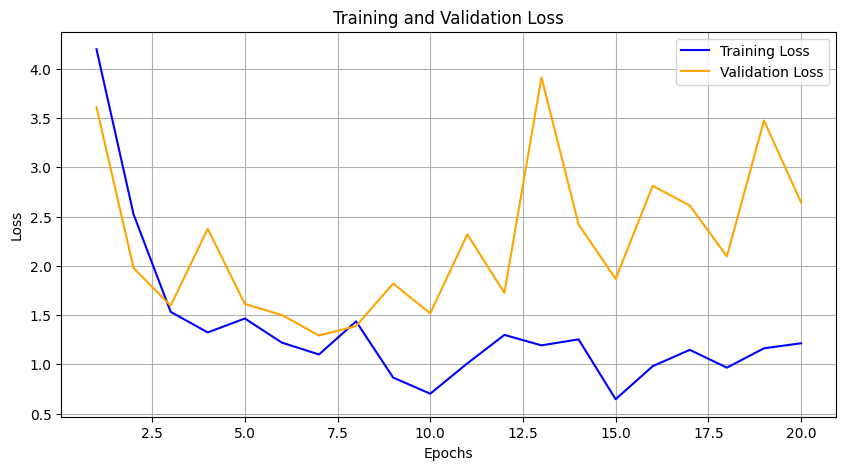

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extraction layers

# Modify the final fully connected layer for 28 classes
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 47)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "AlexNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesAlexNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **AlexNet Testing**

In [7]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'AlexNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=28, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


Loading the best model from AlexNetbest_model.pth


<ipython-input-7-60b52088d642>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 8/8 [01:36<00:00, 12.08s/it]

Top-1 Accuracy: 73.0496
Top-5 Accuracy: 96.4539
mAP: 0.7485
Top-1 Accuracy: 73.0496
Top-5 Accuracy: 96.4539
mAP: 0.7485


## **ResNet18 Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Epoch 1 finished, Train Loss: 3.8387
Epoch 1 finished, Validation Loss: 2.8783
Best model saved with validation loss: 2.8783
Epoch 2 finished, Train Loss: 2.3640
Epoch 2 finished, Validation Loss: 2.0568
Best model saved with validation loss: 2.0568
Epoch 3 finished, Train Loss: 1.5510
Epoch 3 finished, Validation Loss: 1.5699
Best model saved with validation loss: 1.5699
Epoch 4 finished, Train Loss: 1.0411
Epoch 4 finished, Validation Loss: 1.3460
Best model saved with validation loss: 1.3460
Epoch 5 finished, Train Loss: 0.7729
Epoch 5 finished, Validation Loss: 1.1837
Best model saved with validation loss: 1.1837
Epoch 6 finished, Train Loss: 0.6301
Epoch 6 finished, Validation Loss: 1.1121
Best model saved with validation loss: 1.1121
Epoch 7 finished, Train Loss: 0.5054
Epoch 7 finished, Validation Loss: 1.0193
Best model saved with validation loss: 1.0193
Epoch 8 finished, Train Loss: 0.4591
Epoch 8 finished, Validation Loss: 1.0110
Best model saved with validation loss: 1.0110


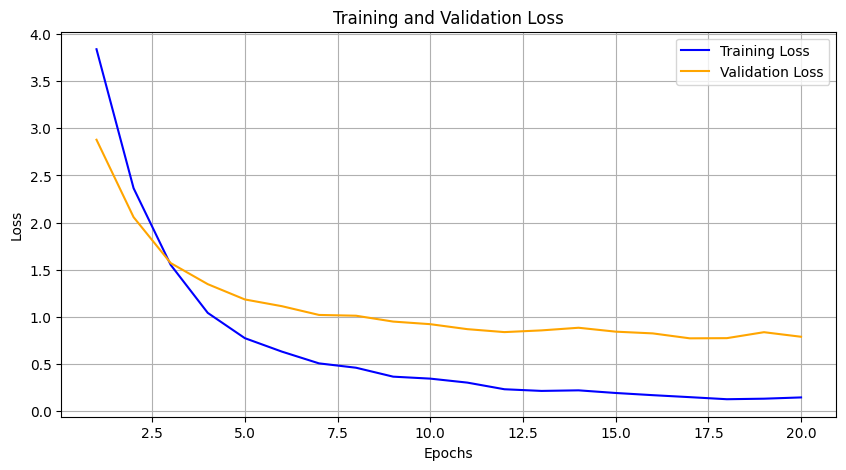

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)  # You can also use resnet50 or resnet101, etc.

# Freeze all convolutional layers (i.e., feature extractor)
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for 28 output classes
num_classes = 47
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "ResNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesResNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **ResNet Testing**

In [9]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'ResNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=47, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-9-1beb32cf02e7>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from ResNetbest_model.pth


100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

Top-1 Accuracy: 80.8511
Top-5 Accuracy: 92.1986
mAP: 0.8054
Top-1 Accuracy: 80.8511
Top-5 Accuracy: 92.1986
mAP: 0.8054


# **VGGNet16 Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 74.4MB/s]


Epoch 1 finished, Train Loss: 5.3000
Epoch 1 finished, Validation Loss: 3.3661
Best model saved with validation loss: 3.3661
Epoch 2 finished, Train Loss: 3.7924
Epoch 2 finished, Validation Loss: 3.0609
Best model saved with validation loss: 3.0609
Epoch 3 finished, Train Loss: 3.3068
Epoch 3 finished, Validation Loss: 2.5324
Best model saved with validation loss: 2.5324
Epoch 4 finished, Train Loss: 3.0249
Epoch 4 finished, Validation Loss: 2.3804
Best model saved with validation loss: 2.3804
Epoch 5 finished, Train Loss: 2.8265
Epoch 5 finished, Validation Loss: 1.9136
Best model saved with validation loss: 1.9136
Epoch 6 finished, Train Loss: 2.4924
Epoch 6 finished, Validation Loss: 1.6451
Best model saved with validation loss: 1.6451
Epoch 7 finished, Train Loss: 2.5550
Epoch 7 finished, Validation Loss: 1.8816
Epoch 8 finished, Train Loss: 2.7114
Epoch 8 finished, Validation Loss: 1.9625
Epoch 9 finished, Train Loss: 2.7619
Epoch 9 finished, Validation Loss: 2.0942
Epoch 10 fini

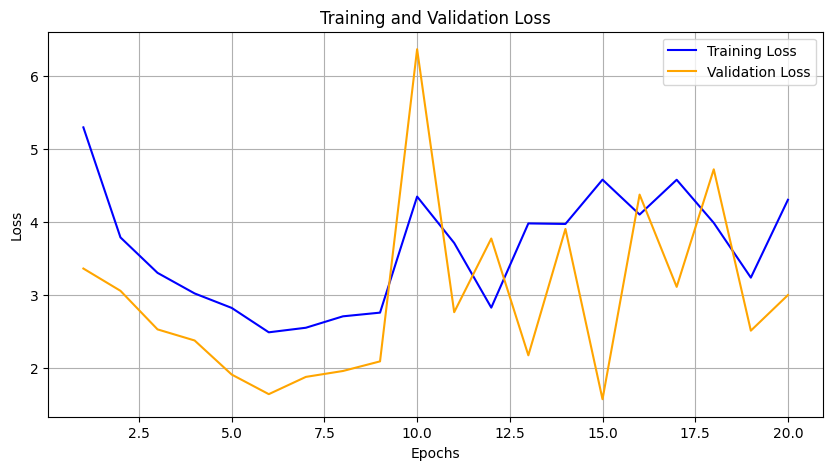

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained VGG16 model
model = models.vgg16(pretrained=True)  # You can also use vgg19

# Freeze all layers except the classifier (fully connected layers)
for param in model.features.parameters():  # Freeze feature extractor (convolutional layers)
    param.requires_grad = False

# Modify the final classifier layer for 28 output classes
num_classes = 47
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "VGGNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesVGGNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **VGGNet16 testing**`

In [11]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'VGGNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=47, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


Loading the best model from VGGNetbest_model.pth


<ipython-input-11-efabcc22e77c>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
100%|██████████| 8/8 [00:01<00:00,  4.99it/s]

Top-1 Accuracy: 82.2695
Top-5 Accuracy: 92.9078
mAP: 0.7965
Top-1 Accuracy: 82.2695
Top-5 Accuracy: 92.9078
mAP: 0.7965


# **GOogleNet(Inveption)**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 74.9MB/s]


Epoch 1 finished, Train Loss: 3.7643
Epoch 1 finished, Validation Loss: 3.2683
Best model saved with validation loss: 3.2683
Epoch 2 finished, Train Loss: 2.7716
Epoch 2 finished, Validation Loss: 2.7592
Best model saved with validation loss: 2.7592
Epoch 3 finished, Train Loss: 2.1044
Epoch 3 finished, Validation Loss: 2.3668
Best model saved with validation loss: 2.3668
Epoch 4 finished, Train Loss: 1.6511
Epoch 4 finished, Validation Loss: 2.1002
Best model saved with validation loss: 2.1002
Epoch 5 finished, Train Loss: 1.3740
Epoch 5 finished, Validation Loss: 1.8738
Best model saved with validation loss: 1.8738
Epoch 6 finished, Train Loss: 1.1215
Epoch 6 finished, Validation Loss: 1.7648
Best model saved with validation loss: 1.7648
Epoch 7 finished, Train Loss: 0.9501
Epoch 7 finished, Validation Loss: 1.6899
Best model saved with validation loss: 1.6899
Epoch 8 finished, Train Loss: 0.8649
Epoch 8 finished, Validation Loss: 1.5980
Best model saved with validation loss: 1.5980


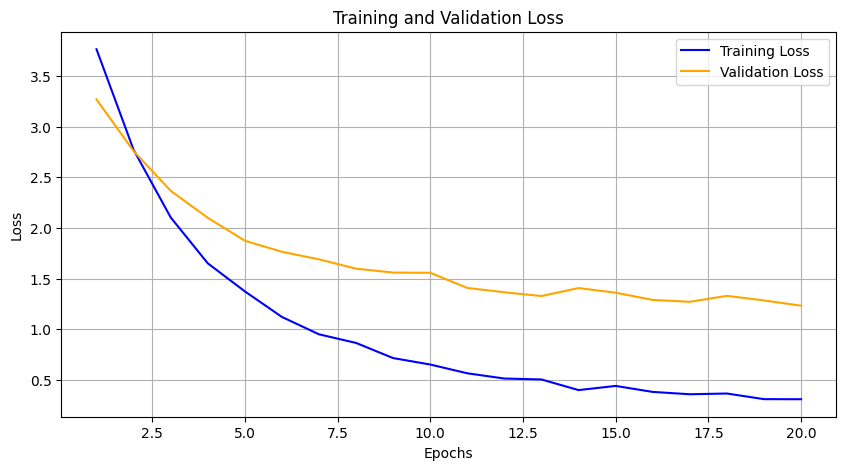

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the pre-trained GoogleNet (Inception v1) model
model = models.googlenet(pretrained=True)  # GoogleNet is available in torchvision

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers
num_classes = 47
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace the final layer with 28 classes

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "GoogleNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesGoogleNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **GoogleNet Testing**

In [13]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'GoogleNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=47, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-13-c30d61469f7e>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from GoogleNetbest_model.pth


100%|██████████| 8/8 [00:01<00:00,  6.59it/s]

Top-1 Accuracy: 80.1418
Top-5 Accuracy: 95.0355
mAP: 0.7772
Top-1 Accuracy: 80.1418
Top-5 Accuracy: 95.0355
mAP: 0.7772


# **EffiecientNet Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


Epoch 1 finished, Train Loss: 3.5958
Epoch 1 finished, Validation Loss: 3.0511
Best model saved with validation loss: 3.0511
Epoch 2 finished, Train Loss: 2.3986
Epoch 2 finished, Validation Loss: 2.3187
Best model saved with validation loss: 2.3187
Epoch 3 finished, Train Loss: 1.7418
Epoch 3 finished, Validation Loss: 1.9886
Best model saved with validation loss: 1.9886
Epoch 4 finished, Train Loss: 1.2682
Epoch 4 finished, Validation Loss: 1.7420
Best model saved with validation loss: 1.7420
Epoch 5 finished, Train Loss: 1.0291
Epoch 5 finished, Validation Loss: 1.6107
Best model saved with validation loss: 1.6107
Epoch 6 finished, Train Loss: 0.8772
Epoch 6 finished, Validation Loss: 1.4774
Best model saved with validation loss: 1.4774
Epoch 7 finished, Train Loss: 0.7289
Epoch 7 finished, Validation Loss: 1.4736
Best model saved with validation loss: 1.4736
Epoch 8 finished, Train Loss: 0.6847
Epoch 8 finished, Validation Loss: 1.2929
Best model saved with validation loss: 1.2929


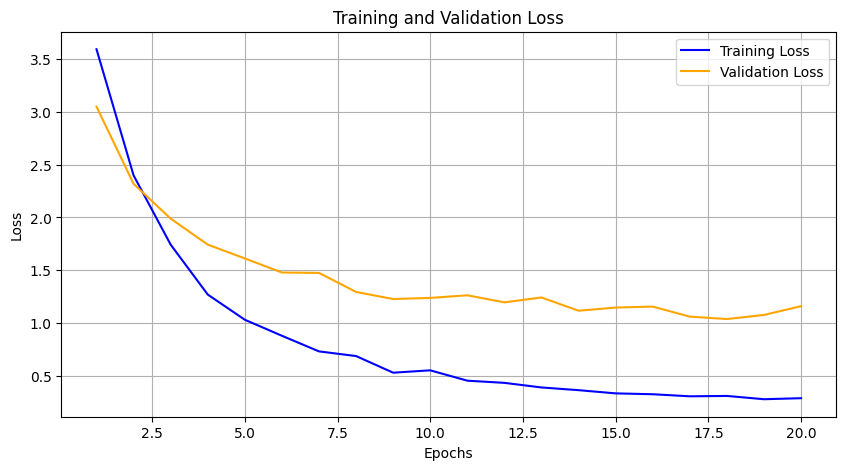

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained EfficientNet model (EfficientNet-B0 is used here)
model = models.efficientnet_b0(pretrained=True)  # Use efficientnet_b0 to efficientnet_b7 for different sizes

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final fully connected layer for 28 output classes
num_classes = 47
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Replace the classifier

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "EfficientNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesEfficientNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **EffiecientNet Testing**

In [15]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'EfficientNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=47, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-15-24909babde40>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from EfficientNetbest_model.pth


100%|██████████| 8/8 [00:01<00:00,  4.91it/s]

Top-1 Accuracy: 80.1418
Top-5 Accuracy: 95.7447
mAP: 0.7785
Top-1 Accuracy: 80.1418
Top-5 Accuracy: 95.7447
mAP: 0.7785


# **DenseNet Training**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 188MB/s]


Epoch 1 finished, Train Loss: 3.6843
Epoch 1 finished, Validation Loss: 3.0997
Best model saved with validation loss: 3.0997
Epoch 2 finished, Train Loss: 2.2016
Epoch 2 finished, Validation Loss: 2.1779
Best model saved with validation loss: 2.1779
Epoch 3 finished, Train Loss: 1.4008
Epoch 3 finished, Validation Loss: 1.6854
Best model saved with validation loss: 1.6854
Epoch 4 finished, Train Loss: 0.9828
Epoch 4 finished, Validation Loss: 1.3835
Best model saved with validation loss: 1.3835
Epoch 5 finished, Train Loss: 0.6909
Epoch 5 finished, Validation Loss: 1.1926
Best model saved with validation loss: 1.1926
Epoch 6 finished, Train Loss: 0.5585
Epoch 6 finished, Validation Loss: 1.1059
Best model saved with validation loss: 1.1059
Epoch 7 finished, Train Loss: 0.4352
Epoch 7 finished, Validation Loss: 1.0449
Best model saved with validation loss: 1.0449
Epoch 8 finished, Train Loss: 0.3571
Epoch 8 finished, Validation Loss: 0.9028
Best model saved with validation loss: 0.9028


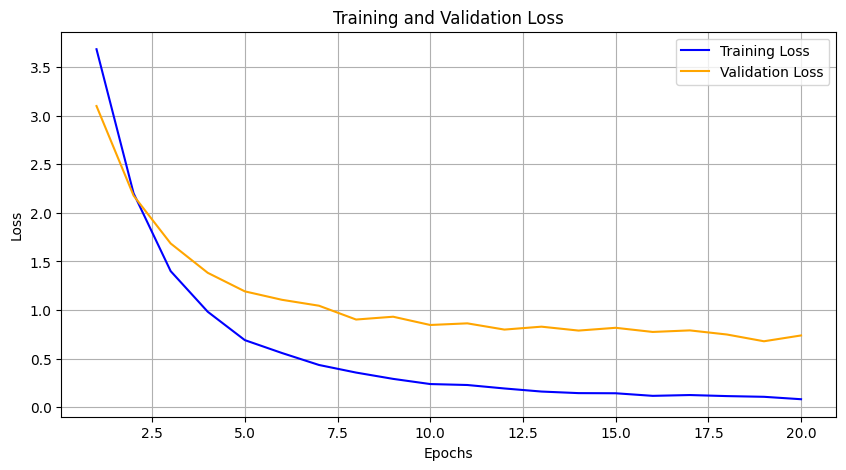

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import os

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained DenseNet model (DenseNet121 is used here)
model = models.densenet121(pretrained=True)  # You can also use densenet169, densenet201

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the final fully connected layer for 28 output classes
num_classes = 47
model.classifier = nn.Linear(model.classifier.in_features, num_classes)  # Replace the classifier

# Move the model to the GPU
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

num_epochs = 20
train_loss_list = []  # To store training loss
val_loss_list = []    # To store validation loss
best_val_loss = float('inf')  # Initialize with infinity to track the best validation loss
best_model_path = "DenseNetbest_model.pth"  # File to store the best model

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Move images and labels to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_list.append((epoch + 1, epoch_train_loss))  # Store epoch number and training loss
    print(f'Epoch {epoch+1} finished, Train Loss: {epoch_train_loss:.4f}')

    # Validation phase
    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        for images, labels in valid_loader:  # Use your validation loader
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    epoch_val_loss = running_val_loss / len(valid_loader)
    val_loss_list.append((epoch + 1, epoch_val_loss))  # Store epoch number and validation loss
    print(f'Epoch {epoch+1} finished, Validation Loss: {epoch_val_loss:.4f}')

    # Save the model if it has the best validation loss so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the model's state dictionary
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")

# Combine and save losses to a CSV file
loss_data = [(epoch, train_loss, val_loss) for (epoch, train_loss), (_, val_loss) in zip(train_loss_list, val_loss_list)]
df = pd.DataFrame(loss_data, columns=['Epoch', 'Train Loss', 'Validation Loss'])
df.to_csv('lossesDenseNet.csv', index=False)

print("Losses saved to 'losses.csv'.")

# Plotting the losses
epochs = [epoch for epoch, _ in train_loss_list]
train_losses = [loss for _, loss in train_loss_list]
val_losses = [loss for _, loss in val_loss_list]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.savefig('loss_plot.png')  # Save the plot as a PNG file
plt.show()  # Display the plot


# **DenseNet Testing**

In [17]:
import torch
import numpy as np
from sklearn.metrics import average_precision_score
from tqdm import tqdm

# Function to calculate mAP (mean Average Precision)
def calculate_map(all_labels, all_scores, num_classes):
    mAP_scores = []
    for c in range(num_classes):
        true_labels = (all_labels == c).astype(int)
        pred_scores = all_scores[:, c]  # Scores for class c

        # Handle case where there are no positive samples
        if true_labels.sum() == 0:
            mAP_scores.append(0.0)
            continue

        ap = average_precision_score(true_labels, pred_scores)
        mAP_scores.append(ap)

    mAP = np.mean(mAP_scores)
    return mAP

# Function to evaluate the model
def evaluate_model(model, test_loader, num_classes, model_path=None):
    # Load the best model if the path is provided
    if model_path is not None:
        print(f"Loading the best model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)

    model.eval()  # Set model to evaluation mode
    top1_correct = 0
    top5_correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_scores = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)  # Move images to the GPU
            labels = labels.to(device)  # Move labels to the GPU

            outputs = model(images)  # Forward pass

            # Get predicted class probabilities
            pred_scores = torch.softmax(outputs, dim=1)  # Shape: (batch_size, num_classes)

            # Get class predictions
            _, predicted = torch.max(outputs, 1)  # Shape: (batch_size,)

            # Top-1 accuracy
            top1_correct += (predicted == labels).sum().item()
            # Top-5 accuracy
            _, top5_pred = torch.topk(outputs, 5, dim=1)
            top5_correct += (top5_pred == labels.view(-1, 1).expand_as(top5_pred)).sum().item()

            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_scores.append(pred_scores.cpu().numpy())  # Append the scores

    # Calculate accuracies
    top1_accuracy = (top1_correct / total) * 100
    top5_accuracy = (top5_correct / total) * 100

    # Concatenate all predicted scores into a 2D array
    all_scores = np.concatenate(all_scores)  # Shape: (num_samples, num_classes)

    # Calculate mean Average Precision (mAP)
    mAP = calculate_map(np.array(all_labels), all_scores, num_classes)

    print(f'Top-1 Accuracy: {top1_accuracy:.4f}')
    print(f'Top-5 Accuracy: {top5_accuracy:.4f}')
    print(f'mAP: {mAP:.4f}')

    return {
        'Top-1 Accuracy': top1_accuracy,
        'Top-5 Accuracy': top5_accuracy,
        'mAP': mAP,
    }

# Example usage
best_model_path = 'DenseNetbest_model.pth'  # Path where the best model is saved
results = evaluate_model(model, test_loader, num_classes=47, model_path=best_model_path)

# Print evaluation results
for metric, value in results.items():
    print(f'{metric}: {value:.4f}')


<ipython-input-17-b972b31304bf>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Loading the best model from DenseNetbest_model.pth


100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

Top-1 Accuracy: 84.3972
Top-5 Accuracy: 97.8723
mAP: 0.7992
Top-1 Accuracy: 84.3972
Top-5 Accuracy: 97.8723
mAP: 0.7992
